### QTW Case Study 6 - "Searching for Exotic Particles in High-Energy Physics with Deep Learning"
### Jayson Barker, Brandon Croom, Shane Weinstock

## Business Understanding

#### The study of particle collisions, especially at high-energy particle colliders, are a key source for identifying exotic particles in the physics community. The discovery of these exotic particles is a difficult task that deep machine learning can help to classify these particles and speed up scientific discoveries. 

#### In the paper "Searching for Exotic Particles in High-Energy Physics with Deep Learning" (https://arxiv.org/pdf/1402.4735.pdf) the researchers build out a deep learning framework to model particle collisions using the Pylearn2 framework. Key features of the model built in this paper are as follows:

* (pg. 6)
>We selected a five-layer neural
network with 300 hidden units in each layer, a learning
rate of 0.05, and a weight decay coefficient of 1 × 10−5.

* (pg. 9, Methods)
>Hidden units all used the tanh activation function.
Weights were initialized from a normal distribution with
zero mean and standard deviation 0.1 in the first layer,
0.001 in the output layer, and 0.05 all other hidden layers

* (pg. 9, Methods)
>  Gradient computations were made on mini-batches
of size 100. A momentum term increased linearly over
the first 200 epochs from 0.9 to 0.99, at which point it
remained constant.

* (pg. 9, Methods)
>Training ended when the momentum had
reached its maximum value and the minimum error on
the validation set (500,000 examples) had not decreased
by more than a factor of 0.00001 over 10 epochs. This
early stopping prevented overfitting and resulted in each
neural network being trained for 200-1000 epochs.

* (pg. 9, Methods)
>Autoencoder pretraining was performed by training a
stack of single-hidden-layer autoencoder networks, then fine-tuning the full network using the class labels. Each autoencoder in the stack used tanh hidden
units and linear outputs, and was trained with the same
initialization scheme, learning algorithm, and stopping
parameters as in the fine-tuning stage. When training
with dropout, we increased the learning rate decay factor
to 1.0000003, and only ended training when the momentum had reached its maximum value and the error on the
validation set had not decreased for 40 epochs.


#### Given that the PyLearn2 framework is no longer in development or support, the goal of our research article will be to replicate the model, defined above, in Tensorflow. Through the analysis we will attempt to replicate the original model as close as possible, call out areas that cannot be replicated, and also provide information on possible improvements to the model that could be developed. Leveraging TensorFlow for the model framework will provide a supported machine learning platform that continues to evolve.

#### NOTE: As the reader proceeds through this document, many of the non critical notebook cells will be collapsed. For further investigation, simply click on the cells to expand the cells to see information contained in them.

## Data Setup and Description

#### In this section the required software libraries for building out the model will be imported, helper functions will be defined and the data will be imported. 

#### The first step will be to setup the libraries for modeling and verify the TensorFlow version. There are nuiances within TensorFlow that sometimes require specific versions. Checking the TensorFlow version will allow for anticipating any issues that may arise. Additionally, the environment will be configured for logging of any errors for investigation.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
from IPython.display import display
%matplotlib inline

# modeling
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import pathlib
import shutil
import tempfile

# sklearn helpers
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
import seaborn as sns

print("TensorFlow Version: " + tf.__version__)

TensorFlow Version: 2.3.0


In [27]:
# Build out Log Directory
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [28]:
# Define Constant Values
FEATURES = 28

In [30]:
# Build out Helper functions
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

def do_model(name,
             features,
             labels,
             base_activation='tanh',
             epochs=200,
             batch_size=100,
             decay_rate=0.5,
             optimizer=None):
    display(md(f"### {name}"))

    initial_learning_rate = 0.05
    if not optimizer:
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=100000,
            decay_rate=decay_rate,
            staircase=True)
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

    # Partition data
    display(md("#### Partition Data"))
    X = features
    y = labels
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.20,
                                                        random_state=7333)
    print("done.")

    # Partition data
    display(md("#### Normalize Data"))
    
    #fit to train data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    #transform test, do not fit
    X_test = scaler.transform(X_test)

    print("done.")

    
    # Build model
    display(md("#### Build Model"))
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(300, activation=base_activation),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(300, activation=base_activation),
        tf.keras.layers.Dense(300, activation=base_activation),
        tf.keras.layers.Dense(300, activation=base_activation),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    print("done.")

    # early stopping callback
    es = EarlyStopping(monitor="accuracy", min_delta=0.01, patience=4)

    display(md("#### Train Model"))
    # fit
    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_test, y_test),
                        callbacks=[es],
                        epochs=epochs,
                        batch_size=batch_size)

    display(md("#### Train/Loss Plot (MSE)"))

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
    ax.ravel()
    #print(history.history)
    p = sns.lineplot(x=range(1,
                             len(history.history['loss']) + 1),
                     y=history.history['loss'],
                     color='blue',
                     label='train',
                     ax=ax[0])
    sns.lineplot(x=range(1,
                         len(history.history['val_loss']) + 1),
                 y=history.history['val_loss'],
                 color='orange',
                 label='validation',
                 ax=ax[0])
    p.set_ylabel('Loss (Blue: Train, Orange: Val.)')
    p.set_xlabel('Epochs')
    p.set_title('Training/Validation Curves')

    # accuracy
    model_scores = model.evaluate(X_test, y_test, verbose=0)

    # AUC
    predictions = model.predict(X_test).ravel()  # predictions
    fpr, tpr, thresholds = roc_curve(y_test, predictions)  # ROC
    auc_metric = auc(fpr, tpr)  # finally AUC

    # print metrics
    display(md("#### Evaluate Model - Metrics"))
    print('Accuracy:', model_scores[1])
    print(f"AUC: {auc_metric}")
    print(f"base_activation: {base_activation}")

    #ROC curve
    p = sns.scatterplot(
        x=fpr,
        y=tpr,
        label=f'Keras NN {base_activation}: AUC {round(auc_metric, 3)}',
        ax=ax[1],
        ci=None)
    p.set_title('ROC Curve')
    plt.show()
    display(md(f"### ----------------------------------"))

    return (model_scores[1], auc_metric) 

#### Now that the environment has been configured the data required for modeling is downloaded. The data used for modeling comes from the UCI Machine Learning Repository. Specifically, the Higgs-Boson data set (https://archive.ics.uci.edu/ml/datasets/HIGGS)  will be leveraged. According the the UCI Machine Learning Repository description the data contains 28 features across 11,000,000 rows. From the website description:

> The first column is the class label (1 for signal, 0 for background), followed by the 28 features (21 low-level features then 7 high-level features): lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb. For more detailed information about each feature see the original paper.

#### Additionally, the data is broken down into three sets of features:
* Low Level Features - Features 1 - 21
* High Level Features - Features 22 - 29
* Mixed (Low & High) Features - All Features

#### For this analysis, all three sets of feature types will be investigated to see if there is a difference.


In [19]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [20]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [21]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

#### Evaluating the data at a high level, the data seems to be normally distributed however there are a few outliers in the data. Given the volume of data it is difficult to tell how much of the data is missing

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


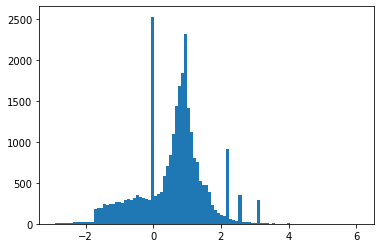

In [22]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

## Model Comparison

#### As previously stated, the key goal of this article is to replicate the original model built in Pylearn2 into a new model built in TensorFlow. A recap of the original model is as follows:

* (pg. 6)
>We selected a five-layer neural
network with 300 hidden units in each layer, a learning
rate of 0.05, and a weight decay coefficient of 1 × 10−5.

* (pg. 9, Methods)
>Hidden units all used the tanh activation function.
Weights were initialized from a normal distribution with
zero mean and standard deviation 0.1 in the first layer,
0.001 in the output layer, and 0.05 all other hidden layers

* (pg. 9, Methods)
>  Gradient computations were made on mini-batches
of size 100. A momentum term increased linearly over
the first 200 epochs from 0.9 to 0.99, at which point it
remained constant.

* (pg. 9, Methods)
>Training ended when the momentum had
reached its maximum value and the minimum error on
the validation set (500,000 examples) had not decreased
by more than a factor of 0.00001 over 10 epochs. This
early stopping prevented overfitting and resulted in each
neural network being trained for 200-1000 epochs.

* (pg. 9, Methods)
>Autoencoder pretraining was performed by training a
stack of single-hidden-layer autoencoder networks, then fine-tuning the full network using the class labels. Each autoencoder in the stack used tanh hidden
units and linear outputs, and was trained with the same
initialization scheme, learning algorithm, and stopping
parameters as in the fine-tuning stage. When training
with dropout, we increased the learning rate decay factor
to 1.0000003, and only ended training when the momentum had reached its maximum value and the error on the
validation set had not decreased for 40 epochs.

#### For the replicated model, the original model will be followed as closely as possible with the following models/parameters:

* Keras Sequential Neural Network
* Keras Optimizers (controls learning decay rate in our Stochastic Gradient Descent (SGD) algorithm) 

The exponential decay of the learning rate at step n of the Stochastic Gradient Descent (SGD) search is controlled by the function:

$$lr_{n}=lr_{0}*d^\frac{n}{ds}$$


Where $lr_{n}$ is the learning rate at step $n$, $lr_{0}$ is the initial learning rate, $d$ is the decay rate and $ds$ is the number of steps where the decay will be applied. This method is slightly different than that used by the researchers (see notes in summary/conclusion)

The researchers initial learning rate of 0.05 will be matched as follows in our model:
* $lr_{0}=0.05$.

The learning rate decay steps ($ds$) will be set to 10,000. Setting the decay rate to 0.50 provides an effective learning rate curve that looks as follows:

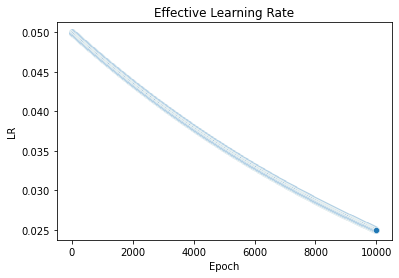

In [ ]:
iters = 10000
epochs = range(1, iters + 1)
learning_rate = 0.05
decay_rate = 0.50
effective_learning_rate = [learning_rate*decay_rate**(n/iters) for n in epochs]
p = sns.scatterplot(x=epochs, y=effective_learning_rate, ci=None)
p.set_title('Effective Learning Rate')
p.set_xlabel('Epoch')
p.set_ylabel('LR')
p

#### These learning rate settings, ideally, will allow the new model to converge more quickly. 

#### In the original research, the researchers were able to set the initial weights of their layers according to specified normal ($N(\mu,\sigma$)) distributions. Keras dense layers do note seem to support this option. Our model will proceed with the default keras implementation which is random initialization. 

#### The new model will consist of:

* an implicit input layer (matching the dimensions of our feature set) 
* 4, 300 node dense tanh activation layers
* 1 50% probability drop out layer between the 1st and second dense layer
* 1 final layer with single node (sigmoid activation)

#### Other key features for the new model include:

* The drop out layer will serve as a regularization layer
* The stopping method will be accuracy based with a minimum delta of 0.01 and patience setting of 4. Training will truncate when an increase of 0.01 in accuracy is not achieved over 4 epochs.
* The **momentum** parameter used in the original model's stopping algorithm is not available for use in the new model. There does not seem to be an implementation in the Keras API. 
* All inputs are scaled to $N(0,1)$ using the sk-learn StandardScaler


#### In order to speed up model build times for comparisons, the new model will leverage 3,000,000 rows of the available 11,000,000 of the data set.

#### For each of the data ranges (Low-level, High-Level, and Mixed - Low & High) the new Tensorflow model will use the same parameters as the original model:

* number of epochs of 200
* activation function of tanh
* batch size of 100
* train/test split of 80/20

In [ ]:
nrows = 3000000
data = pd.read_csv(gz, nrows=nrows, header=None)
data[0] = data[0].astype(int)
print(f"Using {nrows:,.0f} rows of entire dataset")

Using 3,000,000 rows of entire dataset


### Low-level

#### Partition Data

done.


#### Normalize Data

done.


#### Build Model

done.


#### Train Model

Epoch 1/200
24000/24000 [==============================] - 55s 2ms/step - loss: 0.2351 - accuracy: 0.5940 - val_loss: 0.2216 - val_accuracy: 0.6380
Epoch 2/200
24000/24000 [==============================] - 55s 2ms/step - loss: 0.2199 - accuracy: 0.6424 - val_loss: 0.2118 - val_accuracy: 0.6621
Epoch 3/200
24000/24000 [==============================] - 55s 2ms/step - loss: 0.2139 - accuracy: 0.6573 - val_loss: 0.2091 - val_accuracy: 0.6689
Epoch 4/200
24000/24000 [==============================] - 55s 2ms/step - loss: 0.2107 - accuracy: 0.6650 - val_loss: 0.2046 - val_accuracy: 0.6791
Epoch 5/200
24000/24000 [==============================] - 56s 2ms/step - loss: 0.2081 - accuracy: 0.6712 - val_loss: 0.2026 - val_accuracy: 0.6834
Epoch 6/200
24000/24000 [==============================] - 55s 2ms/step - loss: 0.2070 - accuracy: 0.6733 - val_loss: 0.2019 - val_accuracy: 0.6849
Epoch 7/200
24000/24000 [==============================] - 54s 2ms/step - loss: 0.2063 - accuracy: 0.6755 - val_

#### Train/Loss Plot (MSE)

#### Evaluate Model - Metrics

Accuracy: 0.689228355884552
AUC: 0.7557929217309287
base_activation: tanh


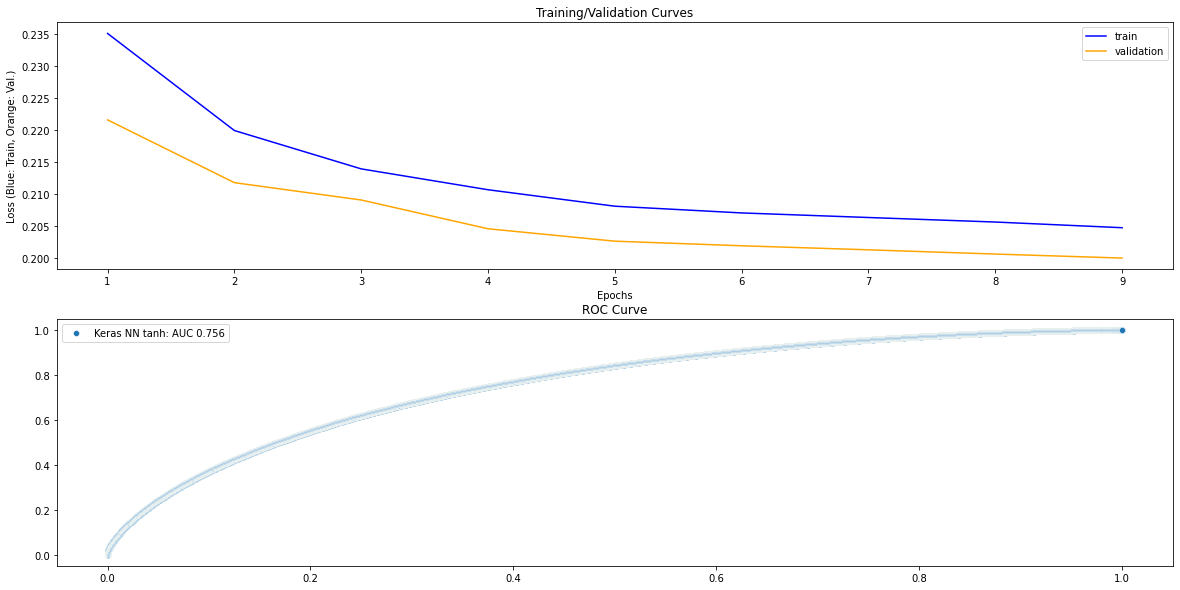

### ----------------------------------

In [ ]:
%matplotlib inline

compare_dict = {}

compare_dict["Low-level"] = do_model("Low-level",
                                     data.iloc[:, range(1, 22)].values,
                                     data[0].values)

#### For the Low-level data analysis using the tanh activation function, the charts above show that the model accuracy is approximately 68.9% and the model AUC is 0.756. The Training/Validation Curves show that it took only 9 Epochs to reach these values.

### High-level

#### Partition Data

done.


#### Normalize Data

done.


#### Build Model

done.


#### Train Model

Epoch 1/200
24000/24000 [==============================] - 56s 2ms/step - loss: 0.2076 - accuracy: 0.6705 - val_loss: 0.1936 - val_accuracy: 0.6975
Epoch 2/200
24000/24000 [==============================] - 55s 2ms/step - loss: 0.1935 - accuracy: 0.6982 - val_loss: 0.1892 - val_accuracy: 0.7058
Epoch 3/200
24000/24000 [==============================] - 54s 2ms/step - loss: 0.1913 - accuracy: 0.7020 - val_loss: 0.1885 - val_accuracy: 0.7071
Epoch 4/200
24000/24000 [==============================] - 54s 2ms/step - loss: 0.1902 - accuracy: 0.7041 - val_loss: 0.1873 - val_accuracy: 0.7093
Epoch 5/200
24000/24000 [==============================] - 54s 2ms/step - loss: 0.1893 - accuracy: 0.7057 - val_loss: 0.1864 - val_accuracy: 0.7107
Epoch 6/200
24000/24000 [==============================] - 56s 2ms/step - loss: 0.1889 - accuracy: 0.7065 - val_loss: 0.1864 - val_accuracy: 0.7103


#### Train/Loss Plot (MSE)

#### Evaluate Model - Metrics

Accuracy: 0.710319995880127
AUC: 0.789171408210637
base_activation: tanh


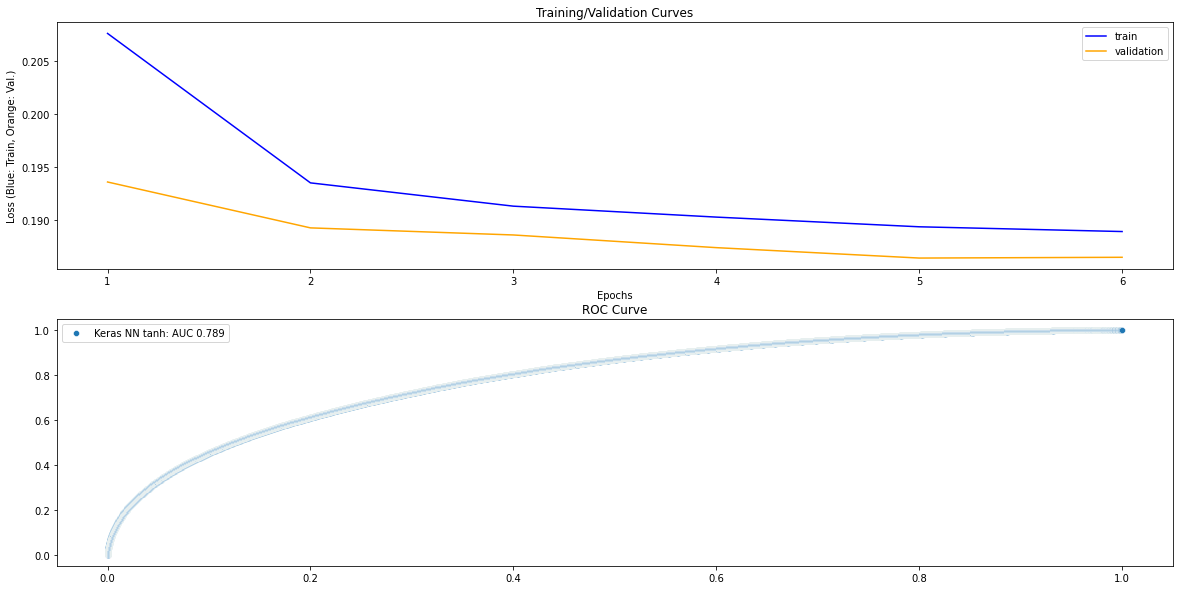

### ----------------------------------

In [ ]:
compare_dict["High-level"] = do_model("High-level",
                                     data.iloc[:, range(22, 29)].values,
                                     data[0].values)

#### For the High-level data analysis using the tanh activation function, the charts above show that the model accuracy is approximately 71.0% and the model AUC is 0.789. The Training/Validation Curves show that it took only 5 Epochs to reach these values.

### Mix-Low+High

#### Partition Data

done.


#### Normalize Data

done.


#### Build Model

done.


#### Train Model

Epoch 1/200
24000/24000 [==============================] - 54s 2ms/step - loss: 0.2101 - accuracy: 0.6667 - val_loss: 0.1871 - val_accuracy: 0.7150
Epoch 2/200
24000/24000 [==============================] - 54s 2ms/step - loss: 0.1875 - accuracy: 0.7138 - val_loss: 0.1773 - val_accuracy: 0.7318
Epoch 3/200
24000/24000 [==============================] - 55s 2ms/step - loss: 0.1804 - accuracy: 0.7264 - val_loss: 0.1735 - val_accuracy: 0.7387
Epoch 4/200
24000/24000 [==============================] - 53s 2ms/step - loss: 0.1773 - accuracy: 0.7319 - val_loss: 0.1719 - val_accuracy: 0.7400
Epoch 5/200
24000/24000 [==============================] - 53s 2ms/step - loss: 0.1751 - accuracy: 0.7356 - val_loss: 0.1703 - val_accuracy: 0.7432
Epoch 6/200
24000/24000 [==============================] - 53s 2ms/step - loss: 0.1741 - accuracy: 0.7374 - val_loss: 0.1689 - val_accuracy: 0.7458
Epoch 7/200
24000/24000 [==============================] - 53s 2ms/step - loss: 0.1734 - accuracy: 0.7388 - val_

#### Train/Loss Plot (MSE)

#### Evaluate Model - Metrics

Accuracy: 0.750190019607544
AUC: 0.8325608083939307
base_activation: tanh


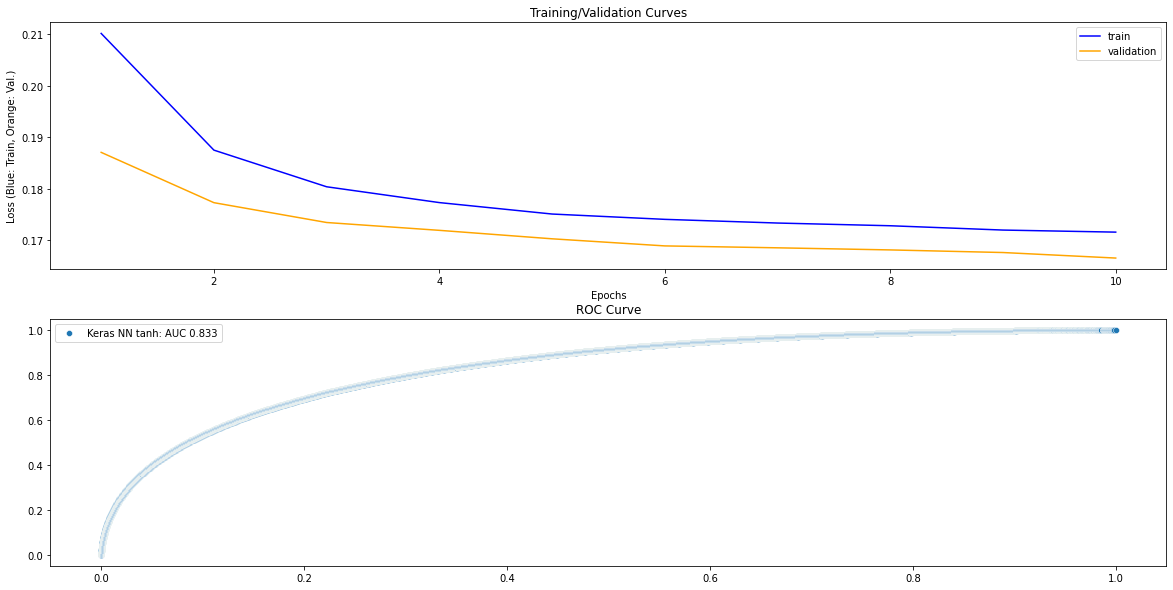

### ----------------------------------

In [ ]:
compare_dict["Mix-Low+High"] = do_model("Mix-Low+High",
                                     data.iloc[:, range(1, 29)].values,
                                     data[0].values)

#### For the mixed data analysis using the tanh activation function, the charts above show that the model accuracy is approximately 75.0% and the model AUC is 0.833. The Training/Validation Curves show that it took only 10 Epochs to reach these values.

## Model Enhancement

#### In this section all three of the models will be re-executed with the Rectified Linear Activation Function (relu). The relu function is a linear function that outputs a positive value or a zero value. It has become the default activation function in current day machine learning due to the ease of training and sometimes better performance. 

#### One of the key differences between the relu and tanh functions is that the tanh function maps values from -1 to 1 thus providing negative inputs a stronger mapping to a negative value and those closer to zero a zero based value. At the time of the paper, the tanh function was considered better than the sigmoid function in much the same way that relu is now considered better than tanh. In all cases, the activation functions must be tested to truly verify this assumption.

### Low-level

#### Partition Data

done.


#### Normalize Data

done.


#### Build Model

done.


#### Train Model

Epoch 1/200
24000/24000 [==============================] - 55s 2ms/step - loss: 0.2316 - accuracy: 0.6068 - val_loss: 0.2209 - val_accuracy: 0.6405
Epoch 2/200
24000/24000 [==============================] - 54s 2ms/step - loss: 0.2214 - accuracy: 0.6389 - val_loss: 0.2130 - val_accuracy: 0.6603
Epoch 3/200
24000/24000 [==============================] - 53s 2ms/step - loss: 0.2151 - accuracy: 0.6549 - val_loss: 0.2066 - val_accuracy: 0.6750
Epoch 4/200
24000/24000 [==============================] - 54s 2ms/step - loss: 0.2111 - accuracy: 0.6647 - val_loss: 0.2051 - val_accuracy: 0.6792
Epoch 5/200
24000/24000 [==============================] - 51s 2ms/step - loss: 0.2084 - accuracy: 0.6708 - val_loss: 0.2026 - val_accuracy: 0.6841
Epoch 6/200
24000/24000 [==============================] - 52s 2ms/step - loss: 0.2072 - accuracy: 0.6736 - val_loss: 0.2019 - val_accuracy: 0.6854
Epoch 7/200
24000/24000 [==============================] - 52s 2ms/step - loss: 0.2062 - accuracy: 0.6759 - val_

#### Train/Loss Plot (MSE)

#### Evaluate Model - Metrics

Accuracy: 0.6907983422279358
AUC: 0.7593621192222076
base_activation: relu


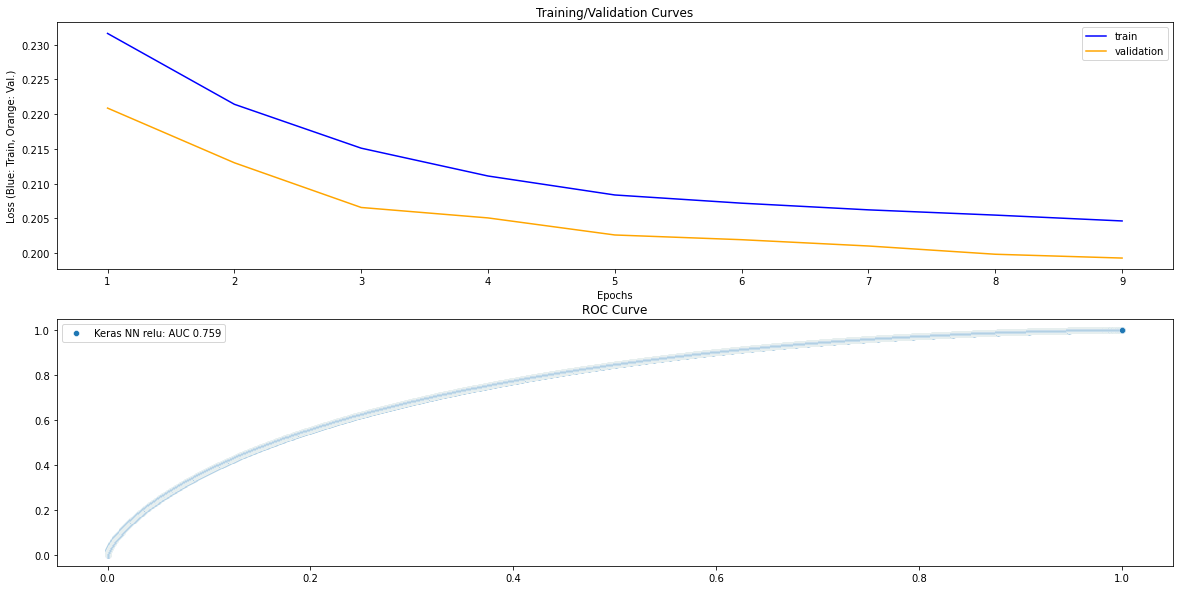

### ----------------------------------

In [23]:
%matplotlib inline



compare_dict["Low-level relu"] = do_model("Low-level",
                                     data.iloc[:, range(1, 22)].values,
                                     data[0].values,
                                     base_activation='relu')

#### For the Low-level data analysis using the relu activation function, the charts above show that the model accuracy is approximately 69.1% and the model AUC is 0.759. The Training/Validation Curves show that it took only 9 Epochs to reach these values.

### High-level

#### Partition Data

done.


#### Normalize Data

done.


#### Build Model

done.


#### Train Model

Epoch 1/200
24000/24000 [==============================] - 50s 2ms/step - loss: 0.2014 - accuracy: 0.6815 - val_loss: 0.1908 - val_accuracy: 0.7021
Epoch 2/200
24000/24000 [==============================] - 51s 2ms/step - loss: 0.1927 - accuracy: 0.6978 - val_loss: 0.1893 - val_accuracy: 0.7052
Epoch 3/200
24000/24000 [==============================] - 51s 2ms/step - loss: 0.1912 - accuracy: 0.7012 - val_loss: 0.1882 - val_accuracy: 0.7074
Epoch 4/200
24000/24000 [==============================] - 50s 2ms/step - loss: 0.1903 - accuracy: 0.7031 - val_loss: 0.1899 - val_accuracy: 0.7038
Epoch 5/200
24000/24000 [==============================] - 50s 2ms/step - loss: 0.1894 - accuracy: 0.7049 - val_loss: 0.1870 - val_accuracy: 0.7092
Epoch 6/200
24000/24000 [==============================] - 51s 2ms/step - loss: 0.1890 - accuracy: 0.7058 - val_loss: 0.1875 - val_accuracy: 0.7087


#### Train/Loss Plot (MSE)

#### Evaluate Model - Metrics

Accuracy: 0.7087016701698303
AUC: 0.7898191989010563
base_activation: relu


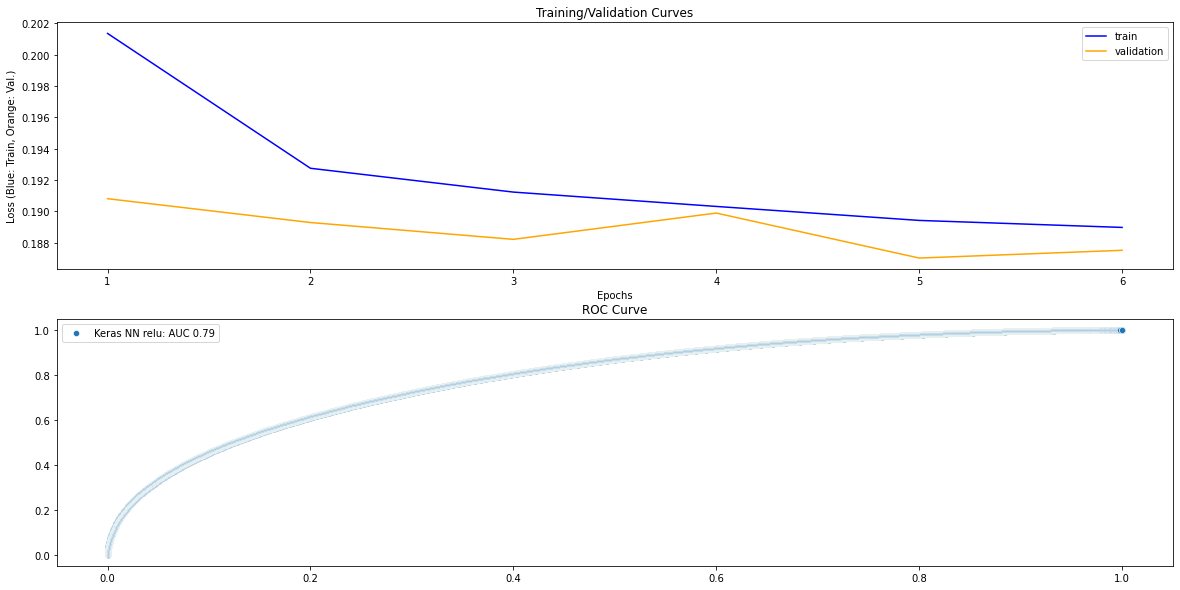

### ----------------------------------

In [24]:
%matplotlib inline

compare_dict["High-level relu"] = do_model("High-level",
                                     data.iloc[:, range(22, 29)].values,
                                     data[0].values,
                                     base_activation='relu')

For the High-level data analysis using the relu activation function, the charts above show that the model accuracy is approximately 71.0% and the model AUC is 0.79. The Training/Validation Curves show that it took only 6 Epochs to reach these values.

### Mix-Low+High

#### Partition Data

done.


#### Normalize Data

done.


#### Build Model

done.


#### Train Model

Epoch 1/200
24000/24000 [==============================] - 52s 2ms/step - loss: 0.2080 - accuracy: 0.6711 - val_loss: 0.1879 - val_accuracy: 0.7132
Epoch 2/200
24000/24000 [==============================] - 51s 2ms/step - loss: 0.1887 - accuracy: 0.7112 - val_loss: 0.1798 - val_accuracy: 0.7278
Epoch 3/200
24000/24000 [==============================] - 50s 2ms/step - loss: 0.1827 - accuracy: 0.7218 - val_loss: 0.1759 - val_accuracy: 0.7338
Epoch 4/200
24000/24000 [==============================] - 51s 2ms/step - loss: 0.1797 - accuracy: 0.7276 - val_loss: 0.1727 - val_accuracy: 0.7390
Epoch 5/200
24000/24000 [==============================] - 53s 2ms/step - loss: 0.1772 - accuracy: 0.7317 - val_loss: 0.1725 - val_accuracy: 0.7400
Epoch 6/200
24000/24000 [==============================] - 53s 2ms/step - loss: 0.1760 - accuracy: 0.7341 - val_loss: 0.1704 - val_accuracy: 0.7435
Epoch 7/200
24000/24000 [==============================] - 53s 2ms/step - loss: 0.1751 - accuracy: 0.7355 - val_

#### Train/Loss Plot (MSE)

#### Evaluate Model - Metrics

Accuracy: 0.7462883591651917
AUC: 0.8316605241579951
base_activation: relu


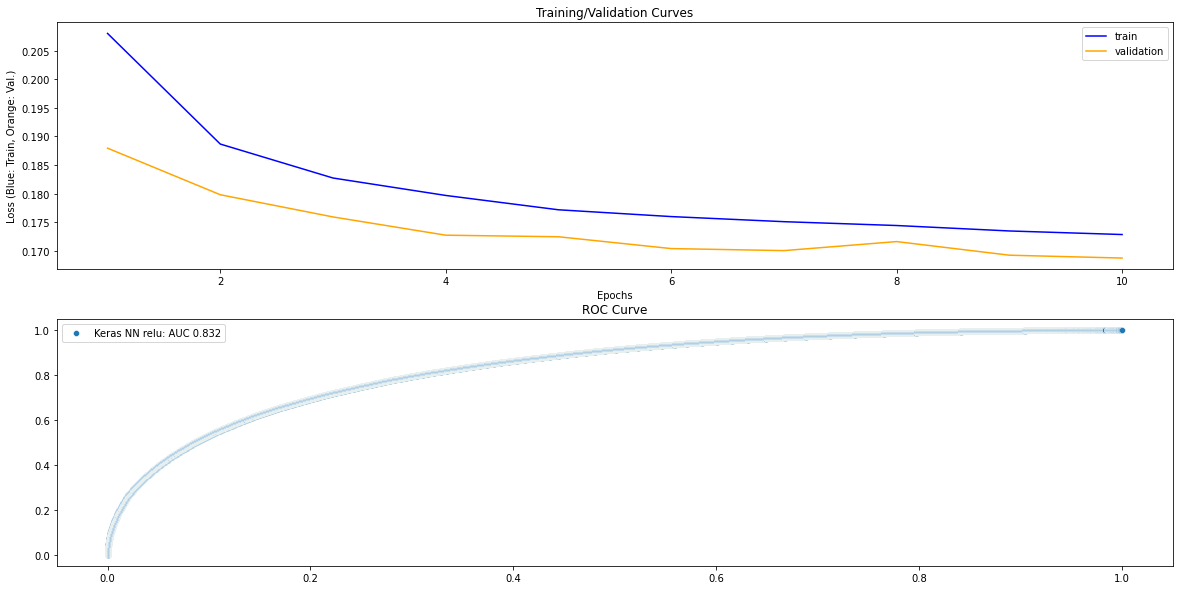

### ----------------------------------

In [25]:
%matplotlib inline

compare_dict["Mix-Low+High relu"] = do_model("Mix-Low+High",
                                     data.iloc[:, range(1, 29)].values,
                                     data[0].values,
                                     base_activation='relu')

For the Mixed-level data analysis using the relu activation function, the charts above show that the model accuracy is approximately 75.0% and the model AUC is 0.832. The Training/Validation Curves show that it took only 10 Epochs to reach these values.

## Model Comparison

#### In comparing model performance the original researchers leveraged the AUC metric as the metric of choice for model evaluation. Over the course of this research article the models we built closely resembled the AUC scores of the original researchers DNN approaches. A summary of the model results comparing the original researcher models and our models using the tanh activation function is shown below:

|||Low Level ||High Level ||All|
|--||----------||----------||----------|
|Theirs|| 0.88||0.80||0.80|
|Ours|| 0.76|| 0.79|| 0.83|

#### Evaluating the relu activation function AUC:

|Low Level ||High Level ||All|
|----------||----------||----------|
| 0.76||0.79||0.83|

#### From this comparison of AUC metrics it can be seen that the models recreated in Tensorflow were relatively close to the original researchers version developed in Pylearn2. It is also seen that in this particular case the activation function in either model did not have a major impact on AUC. Further investigation between the original model and the Tensorflow model could be undertaken. In this analysis the weights in the networks could be analyzed to obtain additional parity between the models and thus possibly bring the AUC scores even closer. This detailed model reimplementation was outside the scope of this current analysis. 

## Conclusion

#### In conclusion we have demonstrated the re-creation of the original model in Tensorflow is possible. The AUC scores between both the original model and the Tensorflow models are relatively close. In addition, our model allowed the flexibility of changing the activation function from tanh to relu. Although this did not greatly impact the AUC scores it did provide more flexibility within the model for future analysis. 

#### Given this additional approach to model implementation there are other opportunities the original researchers could take to further optimize this approach. In the original research, the authors noted that the training hyperparameters were predetermined without optimization. In the Keras framework classifiers may now be used with the same cross validation/grid search architecture found in sk-learn. Leveraging this type of approach could have been extremely beneficial to the researchers as they could have let the computers perform the hyperparameter optimization at runtime versus having them predetermined. This approach would have allowed for varying dropout rates, learning rates, weight decay, and activation functions which provides a much larger parameter space for tuning in a more efficient manner. 

#### At the time of the paper, it seemed that lack of compute power was also a hinderance that may no longer be an issue. With today's cheap and almost unlimited cloud compute power at our fingertips, the researchers may have been able to expanded the dataset used in their hyperparameter search. The availability of graphical processing units (GPUs) and/or Tensorflow processing units (TPUs) would have allowed them to expand their hyperparameter search from the 2.6mm training observations and 100,000 validation records to much more of the data set. 

#### The Tensorflow and Keras frameworks also provided many additional enhancements that the researchers did not have access to. Keras has many classes that would have "automated" many of the "hands on" approaches the researchers took. For example, the researchers took a "hands on" approach to learning rate decay. This allowed them more control over managing this metric, but may have also been time consuming and could have been more "automated" within the Keras framework. There is a trade off to these "automated" versus "hands on" approaches. Given the domain knowledge the researchers had there may have been specific reasons for the more "hands on" approach even if "automated" approaches could have been implemented in Pylearn2.

#### Evaluating standard practices now versus when the paper was written there are a few differences that come about. First, most modern neural network architecture leverages the sigmoid or relu activation functions instead of the tanh activation function. This is due to the simplicity of derivatives for the sigmoid and relu functions. This simplicity typically leads to faster training times. In the examples provided in this article, there was not a large difference seen in training times when comparing the same models on relu and tanh; both models produced similar accuracy and AUC.

#### The second standard that has changed is weight initialization. It it currently best practice to use a random initialization of weights, as was done in the new models. In the original models, the researchers elected to initialize the weights within the hidden layers using a normal distribution by layer. The reasoning for this approach is unclear. It could have been due to technological limitations or domain knowledge dictated it as best practice. 

#### All in all, the results of the original researchers were closely replicated using the Tensorflow framework. The "new" model implementation provides much more flexibility on a framework that is considered the current industry standard. Given improvements in frameworks, model architecture and hardware new models created may be more efficient and allow for a much broader spectrum analysis when compared to the original framework.